In [2]:
# Main
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Modelling
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import pmdarima as pm

import sys
sys.path.append("../scripts")

In [3]:
def flatten(x):
    return [z for y in x for z in y ]

In [4]:
def plot_grid(df, n_cols, figsize):
    n_rows = int(np.ceil(len(df.columns)/n_cols))
    df.plot(subplots=True, layout=(n_rows, n_cols), figsize=figsize)

In [5]:
def plot_fcst(fcst, train=None, test=None):
    ax = fcst.yhat.plot()
    lower = fcst.yhat_lower.interpolate()
    upper = fcst.yhat_upper.interpolate()
    plt.fill_between(fcst.index, y1=lower, y2=upper, alpha=0.3)
    if train is not None:
        train.plot(style="k.")
    if test is not None:
        test.plot(style="r.")

In [6]:
def get_forecastables(df, T=0.5):
    amount_info = df.notna().sum() / len(df)
    forecastable = (amount_info > T)
    return df.loc[:, forecastable].copy()

In [7]:
def get_amount_info(df):
    amount_info = df.notna().sum() / len(df)
    return amount_info

In [8]:
def fourier(steps, seasonality, n_terms=10):
    coeff_list = []
    t = np.arange(0, steps)
    for period in seasonality:
        coeff_M = np.zeros((steps, 2*n_terms))
        for k in range(n_terms):
            coeff_M[:, 2*k] = np.sin(2*np.pi*(k+1)*t/period)
            coeff_M[:, 2*k+1] = np.cos(2*np.pi*(k+1)*t/period)
        coeff_list.append(coeff_M)
    coeff = np.concatenate(coeff_list, axis=1)
    return coeff

In [9]:
plt.rcParams["figure.figsize"] = (14,4)

In [10]:
data = pd.read_csv("../data/base_limpia.csv", parse_dates=["tiempo", "fecha pedido", "fecha liq"])

In [11]:
data.head()

,tiempo,nro factura,cliente,categoria,tipo negocio,localidad,direccion,plaza/campaña,producto,nro pedido,...,u pedidas,kg pedidos,fecha liq,u entregadas,kg entregados,importe bruto,importe factura,sucursal,longitud,latitud
0,2017-05-29,93315173,200008870,a5,mayorista,santa fe,av del valle 7199,plaza,90746,2736812,...,1,1.250,2017-05-29,1,1.250,231.70,12421.88,santa fe,-60.691979,-31.602638
1,2017-06-14,93368453,200008870,a5,mayorista,santa fe,av del valle 7199,plaza,90746,2765668,...,1,1.250,2017-06-14,1,1.250,231.70,19944.84,santa fe,-60.691979,-31.602638
2,2017-02-21,93074208,200008889,a3,supermercado,santa fe,gral.paz 5374,plaza,90740,2546672,...,2,1.464,2017-02-21,2,1.464,324.96,24534.07,santa fe,-60.686356,-31.620964
3,2017-05-11,93270490,200008889,a3,supermercado,santa fe,gral.paz 5374,plaza,90746,2702464,...,1,1.250,2017-05-11,1,1.250,231.70,27204.63,santa fe,-60.686356,-31.620964
4,2017-05-24,93309184,200008889,a3,supermercado,santa fe,gral.paz 5374,plaza,90746,2732609,...,1,1.250,2017-05-24,1,1.250,231.70,16573.12,santa fe,-60.686356,-31.620964


# Forecast por producto

In [12]:
u_producto = pd.pivot_table(
    data, 
    values="u pedidas", 
    index="tiempo", 
    columns="producto", 
    aggfunc="sum").asfreq("D")

In [13]:
u_producto.head()

producto,16034,16061,16062,16070,16071,16075,16076,16077,16080,16081,...,44151,44152,44154,44155,44157,44158,90739,90740,90745,90746
tiempo,,,,,,,,,,,,,,,,,,,,,
2017-01-02,NaN,7.0,1.0,25.0,11.0,3.0,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,1.0,NaN,NaN,4.0,1.0,NaN,NaN
2017-01-03,NaN,21.0,NaN,27.0,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0,NaN,NaN
2017-01-04,NaN,NaN,NaN,8.0,4.0,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN
2017-01-05,NaN,3.0,NaN,6.0,3.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,10.0,NaN,1.0,NaN,1.0,NaN,NaN
2017-01-06,NaN,NaN,2.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


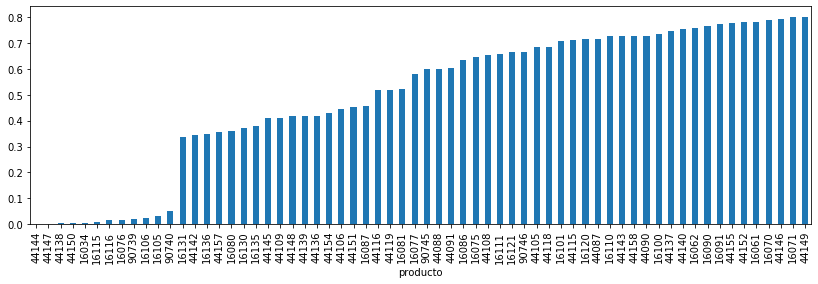

In [14]:
amount_info = get_amount_info(u_producto)
amount_info.sort_values().plot(kind="bar")

In [15]:
u_producto_forecastable = get_forecastables(u_producto, T=0.5)

In [16]:
idx = pd.date_range('2017-01-01', '2019-12-31')
u_producto_forecastable = u_producto_forecastable.reindex(index=idx)

In [17]:
train, test = u_producto_forecastable[:"2018-12-31"].copy(), u_producto_forecastable["2019-01-01":].copy()

In [18]:
train.head()

producto,16061,16062,16070,16071,16075,16077,16081,16086,16090,16091,...,44137,44140,44143,44146,44149,44152,44155,44158,90745,90746
2017-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-02,7.0,1.0,25.0,11.0,3.0,NaN,1.0,NaN,17.0,6.0,...,1.0,1.0,1.0,8.0,14.0,NaN,1.0,NaN,NaN,NaN
2017-01-03,21.0,NaN,27.0,2.0,NaN,NaN,NaN,4.0,21.0,1.0,...,NaN,NaN,NaN,3.0,3.0,NaN,NaN,NaN,NaN,NaN
2017-01-04,NaN,NaN,8.0,4.0,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,4.0,2.0,NaN,1.0,1.0,NaN,NaN
2017-01-05,3.0,NaN,6.0,3.0,NaN,NaN,NaN,NaN,5.0,5.0,...,2.0,3.0,3.0,15.0,16.0,NaN,10.0,1.0,NaN,NaN


In [316]:
item_id = 44149
y_train = train[item_id].interpolate().bfill()
y_test = test[item_id].interpolate().bfill()

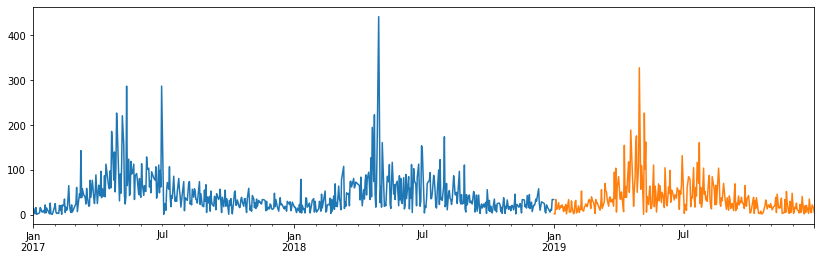

In [317]:
y_train.plot()
y_test.plot()

In [318]:
y_train_boxcox, lmbda = boxcox(y_train)
y_train_boxcox = pd.Series(y_train_boxcox, index=y_train.index)

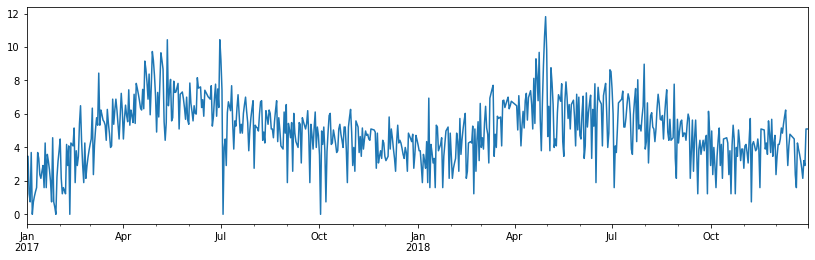

In [319]:
y_train_boxcox.plot()

In [320]:
from tbats import BATS, TBATS

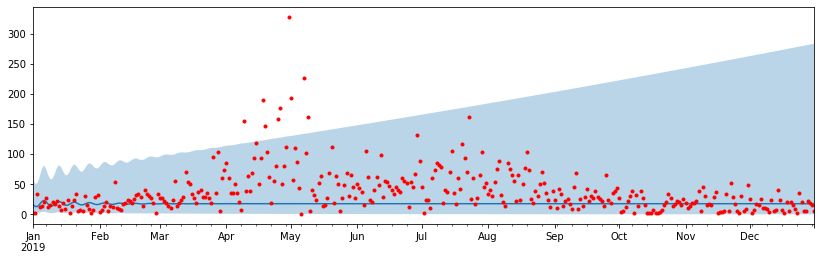

In [323]:
estimator = TBATS(use_box_cox=False, use_trend=False, use_damped_trend=False, seasonal_periods=[365.25])

model = estimator.fit(y_train_boxcox)

fcst = model.forecast(steps=365, confidence_level=0.95)

fcst = pd.DataFrame(fcst[1])

fcst = fcst.rename(columns={"mean":"yhat", "lower_bound":"yhat_lower", "upper_bound":"yhat_upper"})

fcst = fcst.drop(columns="calculated_for_level", errors="ignore")

fcst.index = test.index

fcst = inv_boxcox(fcst, lmbda)

plot_fcst(fcst, test=y_test)

In [194]:
estimator.fit()

0.19777507239136044

In [ ]:
y_train.plot()

In [245]:
# %load "../scripts/prophet_forecaster.py"
#!/usr/bin/env python3

import pandas as pd
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from progress_bar import ProgressBar
from tbats import TBATS

class TBATSForecaster:
    def __init__(self,
        seasonal_periods=(365.25,), 
        use_boxcox=True,
        use_trend=None,
        use_damped_trend=None,
        use_arma_errors=True,
        n_jobs=None):
        
        self.models = dict()
        self.fcst = dict()
        self.lmbda_boxcox = dict()
        self.use_boxcox = use_boxcox    
        self.estimator = TBATS(
            use_box_cox=False,
            seasonal_periods=seasonal_periods,
            use_trend=use_trend,
            use_damped_trend=use_damped_trend,
            use_arma_errors=use_arma_errors,
            n_jobs=n_jobs)
        
        
    def preprocessing(self, train_df):
        return train_df.interpolate().bfill()
    
    def fit(self, train_df):
        print("Fitting...")
        progress_bar = ProgressBar(len(train_df.columns))
        train_df = self.preprocessing(train_df)
        for item in train_df.columns:
            target = train_df[item]
            if self.use_boxcox:
                idx = target.index
                target, self.lmbda_boxcox[item] = boxcox(target)
                target = pd.Series(target, index=idx)
            self.models[item] = self.estimator.fit(target) # Modelling
            progress_bar.update()
        progress_bar.finish()
        return self.models
            
    def predict(self, steps=365, confidence_level=0.8):
        print("Forecasting...")
        progress_bar = ProgressBar(len(self.models.items()))
        for item, model in self.models.items():
            fcst = model.forecast(steps, confidence_level) # Real forecasting step
            fcst = pd.DataFrame(fcst[1]) # The rest is result processing
            fcst = fcst.rename(
                columns={
                    "mean":"yhat", 
                    "lower_bound":"yhat_lower", 
                    "upper_bound":"yhat_upper"})
            fcst = fcst.drop(columns="calculated_for_level")
            self.fcst[item] = fcst
            if self.use_boxcox:
                self.fcst[item] = inv_boxcox(
                    self.fcst[item], 
                    self.lmbda_boxcox[item])
            progress_bar.update()
        progress_bar.finish()
        return pd.concat(self.fcst, axis=1)

In [246]:
products = amount_info.sort_values().tail(1).index

In [247]:
model_tbats = TBATSForecaster()

In [248]:
model_tbats.fit(train[products])

Fitting...


1 of 1|###################################################################|100%


{44149: <tbats.tbats.Model.Model at 0x273ea072148>}

In [249]:
fcst = model_tbats.predict()

Forecasting...


1 of 1|###################################################################|100%


In [250]:
fcst.index = test.index

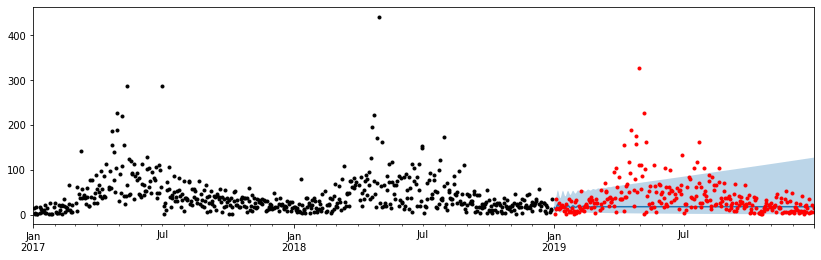

In [251]:
plot_fcst(fcst[44149], test=test[44149], train=train[44149])

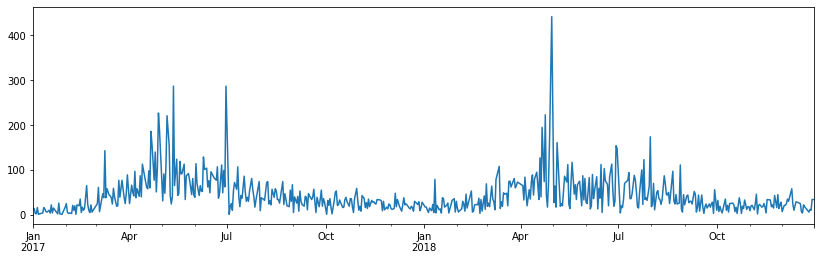

In [258]:
model_tbats.preprocessing(train[44149]).plot()

In [259]:
model_tbats.estimator

C:\Users\ariel\Anaconda3\envs\ml\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


TBATS(box_cox_bounds=(0, 1),
      context=<tbats.tbats.Context.Context object at 0x00000273EA1F8108>,
      n_jobs=None, seasonal_periods=array([365.25]), show_warnings=None,
      use_arma_errors=True, use_box_cox=False, use_damped_trend=None,
      use_trend=None)

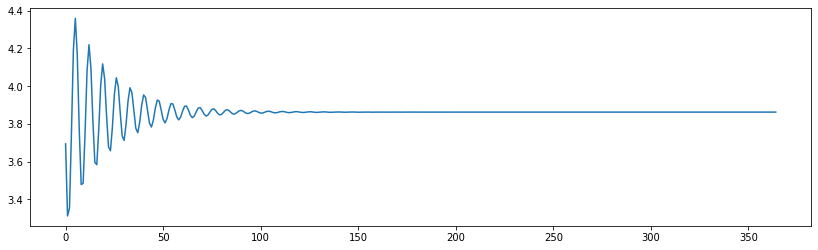

In [268]:
plt.plot(model_tbats.models[44149].forecast(365))